In [58]:
import pandas as pd
import numpy as np
import os
import sys
import json
import requests
import gc
from tqdm import tqdm

from google.cloud import bigquery
from google.cloud.bigquery import job
from datetime import date, timedelta

# 한글 폰트 설정
import matplotlib.font_manager as fm
import matplotlib as mpl

# 나눔고딕 폰트 설정 
font_path = 'C:/Windows/Fonts/malgun.ttf'  # 맑은 고딕 폰트 경로
font_name = fm.FontProperties(fname=font_path).get_name()
mpl.rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

PROJCECT = 'ballosodeuk'
bq = bigquery.Client(project=PROJCECT)

#  클라이언트 설정



### 데이터셋 준비

In [3]:
def get_query(file_path):
    with open(file_path, 'r') as file:
        query = file.read()
    return query

query = get_query('C:/FTC_downloads/code/git/project_hct/01-25/sql/0123_재산전체_미구매.sql')

In [4]:
df = bq.query(query).to_dataframe()

c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


In [2]:
# df.to_parquet('C:/FTC_downloads/code/git/project_hct/01-25/data/df_all_nonpurchase.parquet')
df = pd.read_parquet('C:/FTC_downloads/code/git/project_hct/01-25/data/df_all_nonpurchase.parquet')

In [3]:
df.drop(columns=['gender_1','age_1'], inplace=True)

In [4]:
df = df.query("user_id.notnull()")
df.iloc[:,-1] = df.iloc[:,-1].fillna(0).astype(int)
df['register_dt'] = pd.to_datetime(df.register_dt.astype(str))
# # int, float 컬럼의 NA를 0으로 채우기
numeric_columns = df.select_dtypes(include=['int', 'float']).columns
df[numeric_columns] = df[numeric_columns].fillna(0)
df.fillna(0, inplace=True)

df = df[(df['register_dt'] > '2024-12-30')]
origin_df = df.copy(deep=True)



<ipython-input-4-dd904648db89>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:,-1] = df.iloc[:,-1].fillna(0).astype(int)


In [5]:
# 중복 컬럼 제거
cols = list(dict.fromkeys(origin_df.columns))
origin_df = origin_df[cols]

In [6]:
origin_df.current_shoji.info()

<class 'pandas.core.series.Series'>
Int64Index: 3042411 entries, 160075 to 3202485
Series name: current_shoji
Non-Null Count    Dtype
--------------    -----
3042411 non-null  Int64
dtypes: Int64(1)
memory usage: 49.3 MB


In [7]:
origin_df.groupby('user_id')['register_dt'].transform('min')

160075    2024-12-31
160076    2024-12-31
160077    2024-12-31
160078    2024-12-31
160079    2024-12-31
             ...    
3202481   2025-01-14
3202482   2025-01-16
3202483   2025-01-18
3202484   2025-01-18
3202485   2025-01-19
Name: register_dt, Length: 3042411, dtype: datetime64[ns]

In [8]:
# 선형 회귀로 변화 속도(기울기) 계산
from scipy import stats


In [9]:
df.columns

Index(['register_dt', 'user_id', 'member_no', 'gender', 'age', 'pre_cash',
       'current_cash', 'pre_shoji', 'current_shoji', 'post_shoji_1',
       'post_shoji_2', 'post_shoji_3', 'post_shoji_4', 'post_shoji_5',
       'post_shoji_6', 'post_shoji_7', 'post_shoji_8', 'post_shoji_9',
       'post_shoji_10', 'post_shoji_11', 'post_shoji_12', 'post_shoji_13',
       'burnt', 'exchange', 'exchange_cash_rate'],
      dtype='object')

# 피처 엔지니어링

### churn date 결정

In [10]:
churn_date = pd.Timestamp('2025-01-15')
last_visit = df.groupby('user_id')['register_dt'].max()
df['churn'] = df['user_id'].map(last_visit < churn_date)

### cencored 날짜 보간
- 유저 별 이벤트 미발생일을 직전 이벤트 날짜로 보간
- cencored date 이하는 Null 처리
- 필요 정보 추출 및 통계치 정리

In [11]:
df['first_register_dt'] = df.groupby('user_id')['register_dt'].transform('first')


In [12]:
# 1. 날짜 범위 생성
date_range = pd.date_range(df['register_dt'].min(), df['register_dt'].max(), freq='D')
all_dates = pd.DataFrame(date_range, columns=['register_dt'])

# 2. 모든 유저와 날짜의 조합 생성
users = df[['user_id', 'member_no', 'gender', 'age']].drop_duplicates()
full_df = users.merge(all_dates, how='cross')

# 3-6. 원본 데이터와 병합 및 데이터 처리
result_df = full_df.merge(df, on=['register_dt', 'user_id', 'member_no', 'gender', 'age'], how='left')

# added 열 추가
result_df['added'] = result_df['burnt'].isna()

# # 일일 발생 데이터 0으로 채우기
# daily_cols = ['burnt', 'exchange', 'exchange_cash_rate']
# result_df.loc[result_df['added'] == True, daily_cols] = result_df.loc[result_df['added'] == True, daily_cols].fillna(0)

# # 누적 데이터 forward fill
# cumulative_cols = [
#         'pre_cash', 'current_cash', 'pre_shoji', 'current_shoji',
#         'post_shoji_1', 'post_shoji_2', 'post_shoji_3', 'post_shoji_4',
#         'post_shoji_5', 'post_shoji_6', 'post_shoji_7', 'post_shoji_8',
#         'post_shoji_9', 'post_shoji_10', 'post_shoji_11', 'post_shoji_12',
#         'post_shoji_13']  # 필요한 누적 컬럼 추가
# result_df[cumulative_cols] = result_df[cumulative_cols].astype(float)
# # NaN과 <NA>를 모두 처리
# result_df[cumulative_cols] = result_df[cumulative_cols].replace({pd.NaT: pd.NA, None: pd.NA})  # <NA> 처리
# result_df[cumulative_cols] = result_df.groupby('user_id')[cumulative_cols].fillna(method='ffill')

# result_df


In [13]:

sp = result_df.query('added == True').sample().user_id.values[0]
tst = result_df.query('user_id == @sp')
tst
# tst[cols_to_process] = tst.groupby('user_id')[cols_to_process].fillna(method='ffill')
# tst

,user_id,member_no,gender,age,register_dt,pre_cash,current_cash,pre_shoji,current_shoji,post_shoji_1,...,post_shoji_10,post_shoji_11,post_shoji_12,post_shoji_13,burnt,exchange,exchange_cash_rate,churn,first_register_dt,added
2540787,256a2b16-ac6a-473c-aaa1-366d36fa54d4,98993569,FEMALE,50,2024-12-31,4238,4238,10,209,0,...,0,0,0,0,0,0,0.0,True,2024-12-31,False
2540788,256a2b16-ac6a-473c-aaa1-366d36fa54d4,98993569,FEMALE,50,2025-01-01,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaT,True
2540789,256a2b16-ac6a-473c-aaa1-366d36fa54d4,98993569,FEMALE,50,2025-01-02,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaT,True
2540790,256a2b16-ac6a-473c-aaa1-366d36fa54d4,98993569,FEMALE,50,2025-01-03,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaT,True
2540791,256a2b16-ac6a-473c-aaa1-366d36fa54d4,98993569,FEMALE,50,2025-01-04,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaT,True
2540792,256a2b16-ac6a-473c-aaa1-366d36fa54d4,98993569,FEMALE,50,2025-01-05,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaT,True
2540793,256a2b16-ac6a-473c-aaa1-366d36fa54d4,98993569,FEMALE,50,2025-01-06,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaT,True
2540794,256a2b16-ac6a-473c-aaa1-366d36fa54d4,98993569,FEMALE,50,2025-01-07,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaT,True
2540795,256a2b16-ac6a-473c-aaa1-366d36fa54d4,98993569,FEMALE,50,2025-01-08,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaT,True
2540796,256a2b16-ac6a-473c-aaa1-366d36fa54d4,98993569,FEMALE,50,2025-01-09,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaT,True


### 주기 반영한 계산 
- 기울기, 보상 주기

In [14]:

def calculate_slopes(df):
    df['days'] = (df['register_dt'] - df['register_dt'].min()).dt.days
    slope_df = df[['user_id', 'days', 'current_shoji']].astype({'current_shoji': float})
    
    def get_slope(group):
        if len(group) > 1:
            x = group['days'].values
            y = group['current_shoji'].values
            return stats.linregress(x, y)[0]
        return np.nan
    
    slopes = slope_df.groupby('user_id').apply(get_slope)
    return slopes

origin_df['slope_dt'] = origin_df['user_id'].map(calculate_slopes(origin_df))


In [15]:
def calculate_event_periods(df):
   # 이벤트 발생일만 필터링 (burnt > 0)
#    df = df[df['burnt'] > 0].copy()
   
   # 유저별 이벤트 날짜 정렬
   df = df.sort_values(['user_id', 'register_dt'])
   
   # 이전 이벤트와의 날짜 차이 계산
   df['days_between'] = df.groupby('user_id')['register_dt'].diff().dt.days
   
   # 유저별 평균 주기 계산
   avg_periods = df.groupby('user_id')['days_between'].mean()
   
   return avg_periods

origin_df['avg_event_period'] = origin_df['user_id'].map(calculate_event_periods(df))

In [16]:
def evaluate_users(df):
   # NaN 제외하고 z-score 계산
   valid_mask = df['avg_event_period'].notna() & df['slope_dt'].notna()
   
   event_zscore = pd.Series(index=df.index, dtype=float)
   slope_zscore = pd.Series(index=df.index, dtype=float)
   
   event_zscore[valid_mask] = stats.zscore(df.loc[valid_mask, 'avg_event_period'])
   slope_zscore[valid_mask] = stats.zscore(df.loc[valid_mask, 'slope_dt'])
   
   combined_score = -event_zscore + slope_zscore
   
   # NaN은 별도 카테고리로 분류
   percentile = pd.qcut(combined_score[valid_mask], q=4, labels=['Low', 'Medium', 'High', 'VeryHigh'])
   result = pd.Series(index=df.index, data='Inactive')
   result[valid_mask] = percentile
   
   return result

origin_df['user_tier'] = evaluate_users(origin_df)

In [241]:
origin_df.columns

Index(['register_dt', 'user_id', 'member_no', 'gender', 'age', 'pre_cash',
       'current_cash', 'pre_shoji', 'current_shoji', 'post_shoji_1',
       'post_shoji_2', 'post_shoji_3', 'post_shoji_4', 'post_shoji_5',
       'post_shoji_6', 'post_shoji_7', 'post_shoji_8', 'post_shoji_9',
       'post_shoji_10', 'post_shoji_11', 'post_shoji_12', 'post_shoji_13',
       'burnt', 'exchange', 'exchange_cash_rate', 'days', 'slope_dt',
       'avg_event_period', 'churn', 'burnt_cnt', 'exchange_cnt', 'duration',
       'user_tier'],
      dtype='object')

In [17]:
last_visit = origin_df.groupby('user_id')['register_dt'].max()
origin_df['churn'] = origin_df['user_id'].map(last_visit < pd.Timestamp('2025-01-15'))
origin_df['burnt_cnt'] = origin_df.burnt.apply(lambda x: 1 if x > 0 else 0)
origin_df['exchange_cnt'] = origin_df.exchange.apply(lambda x: 1 if x > 0 else 0)
origin_df['duration'] = (origin_df.groupby('user_id')['register_dt'].transform('max') - origin_df['register_dt']).dt.days
# origin_df.loc[origin_df['churn'] == False, 'duration'] = 9999

cash_diff = origin_df.groupby('user_id').agg({
   'register_dt': ['first', 'last'],
   'current_cash': ['first', 'last']
}).reset_index()

shoji_diff = origin_df.groupby('user_id').agg({
   'register_dt': ['first', 'last'],
   'current_shoji': ['first', 'last']
}).reset_index()

cash_diff['cash_difference'] = cash_diff['current_cash']['first'] - cash_diff['current_cash']['last']
shoji_diff['shoji_difference'] = shoji_diff['current_shoji']['last'] - shoji_diff['current_shoji']['first']

grp = origin_df.groupby('user_id').agg({
   'churn': 'first',
   'duration': 'first',
   'register_dt': 'first',
   'gender': 'first',
   'age': 'first',
   'days':'first', 
   'user_tier':'first',
   'slope_dt':'first',
   'avg_event_period':'first',
   # 'pre_cash': 'last',
   'current_cash': 'last',
   # 'pre_shoji': 'first',
   'current_shoji':['first','last'],
   'post_shoji_1': 'first',
   'post_shoji_2': 'first',
   'post_shoji_3': 'first',
   'post_shoji_4': 'first', 
   'post_shoji_5': 'first',
   'post_shoji_6': 'first',
   'post_shoji_7': 'first',
   'post_shoji_8': 'first',
   'post_shoji_9': 'first',
   'post_shoji_10': 'first',
   'post_shoji_11': 'first',
   'post_shoji_12': 'first',
   'post_shoji_13': 'first',
   'burnt': 'sum',
   'burnt_cnt': 'sum',
   'exchange_cnt': 'sum',
   'exchange_cash_rate': 'sum'
}).reset_index()

cash_diff.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0] for col in cash_diff.columns]
shoji_diff.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0] for col in shoji_diff.columns]
grp.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0] for col in grp.columns]

grp = pd.merge(grp, cash_diff[['user_id','cash_difference']], on='user_id', how='left')
grp = pd.merge(grp, shoji_diff[['user_id','shoji_difference']], on='user_id', how='left')

grp = grp.query("user_id.str.len() > 1")


In [18]:
grp.rename(columns={'current_shoji_first':'current_shoji-first', 'current_shoji_last':'current_shoji-last'}, inplace=True)
grp.columns = grp.columns.str.replace('_first', '')
grp.columns = grp.columns.str.replace('_last', '')  
grp.columns = grp.columns.str.replace('_sum', '')

In [264]:
grp.tail()

,user_id,churn,duration,register_dt,gender,age,days,user_tier,slope_dt,avg_event_period,current_cash,current_shoji-first,current_shoji-last,post_shoji_1,post_shoji_2,post_shoji_3,post_shoji_4,post_shoji_5,post_shoji_6,post_shoji_7,post_shoji_8,post_shoji_9,post_shoji_10,post_shoji_11,post_shoji_12,post_shoji_13,burnt,burnt_cnt,exchange_cnt,exchange_cash_rate,cash_difference,shoji_difference,current_cash_bin,cash_diff_bin
252150,ffff4ddd-d4b3-4df1-bcb1-545edba93d13,True,12,2024-12-31,FEMALE,30,0,Medium,5.565358,1.090909,5284,3,79,16,25,34,37,40,46,49,55,58,64,79,0,0,0,0,0,0,0,76,3000~6000,NaN
252151,ffff92f1-7756-49e9-88e9-f2e545ecddb9,False,22,2024-12-31,FEMALE,50,0,Medium,10.187402,1.294118,17951,60,318,75,81,155,188,191,200,255,258,270,273,279,282,291,0,0,0,0,0,258,15000~18000,NaN
252152,ffff9afc-f69f-4c83-812f-8454f740abfb,False,22,2024-12-31,FEMALE,60,0,High,50.330753,1.100000,23022,75,1149,86,205,217,397,409,432,442,523,571,700,770,783,888,0,0,0,0,0,1074,21000~24000,NaN
252153,ffff9c5c-d657-486e-97dd-716f6af8a429,False,22,2024-12-31,MALE,50,0,Low,4.105660,3.142857,6608,18,120,33,48,63,75,90,105,120,0,0,0,0,0,0,0,0,0,0,0,102,6000~9000,NaN
252154,fffff0da-172e-421f-87be-12324d714cbd,False,22,2024-12-31,FEMALE,40,0,VeryHigh,126.818705,1.157895,14265,632,3638,751,861,1526,1636,1640,1750,2062,2162,2262,2371,2481,2581,2731,0,0,18,4400,3800,3006,12000~15000,3000~6000


In [19]:
del df,full_df,result_df,origin_df,sp,tst
gc.collect()

14

In [276]:
print("보상 활동 시작 코호트 : ",grp.register_dt.min(), grp.register_dt.max())
grp = grp.query('register_dt < "2025-01-14"')



보상 활동 시작 코호트 :  2024-12-31 00:00:00 2025-01-13 00:00:00


In [20]:
# 이탈여부 평균 생존기간 (횟수)
grp.groupby('churn').agg({'duration':['mean','std']})


duration          
            mean       std
churn                     
False  19.234982  5.299297
True    3.785465  4.497247

In [273]:
grp.columns

Index(['user_id', 'churn', 'duration', 'register_dt', 'gender', 'age', 'days',
       'user_tier', 'slope_dt', 'avg_event_period', 'current_cash',
       'current_shoji-first', 'current_shoji-last', 'post_shoji_1',
       'post_shoji_2', 'post_shoji_3', 'post_shoji_4', 'post_shoji_5',
       'post_shoji_6', 'post_shoji_7', 'post_shoji_8', 'post_shoji_9',
       'post_shoji_10', 'post_shoji_11', 'post_shoji_12', 'post_shoji_13',
       'burnt', 'burnt_cnt', 'exchange_cnt', 'exchange_cash_rate',
       'cash_difference', 'shoji_difference', 'current_cash_bin',
       'cash_diff_bin'],
      dtype='object')

In [251]:
grp.groupby(['user_tier','churn']).agg({
    'user_id':'count',
    'exchange_cnt':'mean','burnt_cnt':'mean','exchange_cash_rate':'mean',
    'cash_difference':'mean','shoji_difference':'mean',
    'current_cash':'mean',
    'current_shoji-first':'mean','current_shoji-last':'mean',
    'slope_dt':'mean',
    'avg_event_period':'mean',
    })


user_id  exchange_cnt  burnt_cnt  exchange_cash_rate  \
user_tier churn                                                         
High      False    34495      0.467894   0.009132          125.392086   
          True      2850      0.202456   0.005263           81.754386   
Inactive  True     27707      0.015880   0.041939           25.170535   
Low       False    71067      0.105731   0.029690           34.961374   
          True     23021      0.079102   0.022110           57.347639   
Medium    False    37719      0.210955   0.010287           59.699356   
          True      7863      0.066005   0.005850           22.561363   
VeryHigh  False    32749      4.040123   0.009955         2185.849950   
          True      3268      0.775704   0.011628          866.462668   

                 cash_difference  shoji_difference  current_cash  \
user_tier churn                                                    
High      False       114.689085       1204.072271  21725.403189   
          True         68.982456        374.500702  17624.778596   
Inactive  True               0.0               0.0   6131.210272   
Low       False        28.190299         32.259206    8705.60329   
          True         49.789323        -38.916468   8442.754268   
Medium    False        52.233622         483.41491  12866.122061   
          True         16.456823        100.586036  10141.307389   
VeryHigh  False      2114.666097       2945.842346  26671.626279   
          True         810.03672       1092.793758  19465.988372   

                 current_shoji-first  current_shoji-last    slope_dt  \
user_tier churn                                                        
High      False           985.071779          2189.14405   54.775408   
          True            364.113684          738.614386   55.061181   
Inactive  True            194.092143          194.092143         NaN   
Low       False           478.233231          510.492437    1.528055   
          True            321.542548          282.626081  -15.858363   
Medium    False           502.273284          985.688194   22.566063   
          True            234.768155          335.354191   17.454547   
VeryHigh  False          1202.461816         4148.304162  135.836597   
          True            560.872399         1653.666157  175.186054   

                 avg_event_period  
user_tier churn                    
High      False          1.076804  
          True           1.109452  
Inactive  True                NaN  
Low       False          3.423349  
          True           3.674670  
Medium    False          1.202471  
          True           1.110544  
VeryHigh  False          1.033709  
          True           1.114988

In [86]:
grp.groupby('age').agg({'churn':'sum','user_id':'count'})

,churn,user_id
age,,
10,2034,4058
20,6902,19222
30,12467,41115
40,21830,84078
50,16083,72402
60,5252,25513
70,937,4920
80,128,732
90,16,68


In [21]:
pd.set_option('display.max_rows', None)
# current_cash를 3000 단위로 구간화하여 새로운 컬럼 생성
grp['current_cash_bin'] = pd.cut(grp['current_cash'], 
                                bins=range(0, int(grp['current_cash'].max()) + 3000, 3000),
                                labels=[f'{i}~{i+3000}' for i in range(0, int(grp['current_cash'].max()), 3000)])

# 구간별 이탈 건수 확인
churn_by_cash = grp.groupby(['current_cash_bin', 'churn'])['user_id'].count().unstack()
print("현금 보유량 구간별 이탈/생존 건수:")
churn_by_cash


현금 보유량 구간별 이탈/생존 건수:


churn,False,True
current_cash_bin,,
0~3000,40551,25768
3000~6000,28292,10798
6000~9000,19850,6336
9000~12000,14928,4340
12000~15000,11197,2988
15000~18000,9285,2401
18000~21000,8155,1869
21000~24000,7288,1512
24000~27000,6444,1296


In [22]:
grp.columns

Index(['user_id', 'churn', 'duration', 'register_dt', 'gender', 'age', 'days',
       'user_tier', 'slope_dt', 'avg_event_period', 'current_cash',
       'current_shoji-first', 'current_shoji-last', 'post_shoji_1',
       'post_shoji_2', 'post_shoji_3', 'post_shoji_4', 'post_shoji_5',
       'post_shoji_6', 'post_shoji_7', 'post_shoji_8', 'post_shoji_9',
       'post_shoji_10', 'post_shoji_11', 'post_shoji_12', 'post_shoji_13',
       'burnt', 'burnt_cnt', 'exchange_cnt', 'exchange_cash_rate',
       'cash_difference', 'shoji_difference', 'current_cash_bin'],
      dtype='object')

In [25]:
# current_cash를 3000 단위로 구간화하여 새로운 컬럼 생성
bins = [*range(0, 102000, 3000), 102000, float('inf')]
labels = [f'{i}~{i+3000}' for i in range(0, 102000, 3000)] + ['102000~']
grp['current_cash_bin'] = pd.cut(grp['current_cash'], 
                                bins=bins,
                                labels=labels)

# cash_difference를 1000 이하/이상으로 구분
bins = [-float('inf'), 1000, float('inf')]
labels = ['1000 이하', '1000 이상']
grp['cash_diff_bin'] = pd.cut(grp['cash_difference'],
                             bins=bins,
                             labels=labels)

# 구간별 이탈 건수 확인
churn_by_cash = grp.groupby(['cash_diff_bin','current_cash_bin', 'churn'])['user_id'].count().unstack()
print("현금 보유량 및 현금 차이 구간별 이탈/생존 건수:")
churn_by_cash


현금 보유량 및 현금 차이 구간별 이탈/생존 건수:


churn                           False  True 
cash_diff_bin current_cash_bin              
1000 이하       0~3000            39080  25595
              3000~6000         27348  10759
              6000~9000         18869   6296
              9000~12000        13970   4303
              12000~15000       10343   2961
              15000~18000        8451   2376
              18000~21000        7306   1844
              21000~24000        6495   1493
              24000~27000        5704   1279
              27000~30000        5177   1125
              30000~33000        4739    904
              33000~36000        3970    694
              36000~39000        3384    599
              39000~42000        2949    493
              42000~45000        2377    356
              45000~48000        1859    273
              48000~51000        1609    194
              51000~54000        1310    171
              54000~57000        1093    123
              57000~60000         830    110
              60000~63000         614     63
              63000~66000         485     57
              66000~69000         337     61
              69000~72000         266     24
              72000~75000         174     23
              75000~78000          97     19
              78000~81000         102     10
              81000~84000          57      4
              84000~87000          39      7
              87000~90000          34      4
              90000~93000          32      0
              93000~96000          18      4
              96000~99000          15      2
              99000~102000          7      1
              102000~              44      5
1000 이상       0~3000             1471    173
              3000~6000           944     39
              6000~9000           981     40
              9000~12000          958     37
              12000~15000         854     27
              15000~18000         834     25
              18000~21000         849     25
              21000~24000         793     19
              24000~27000         740     17
              27000~30000         731     19
              30000~33000         675     23
              33000~36000         619     22
              36000~39000         492     11
              39000~42000         495     14
              42000~45000         403      5
              45000~48000         353      5
              48000~51000         262      5
              51000~54000         217     12
              54000~57000         205      4
              57000~60000         157      1
              60000~63000         120      2
              63000~66000         104      1
              66000~69000          64      1
              69000~72000          46      1
              72000~75000          39      3
              75000~78000          30      0
              78000~81000          14      1
              81000~84000          15      0
              84000~87000          18      1
              87000~90000           8      1
              90000~93000           6      0
              93000~96000           6      0
              96000~99000           3      0
              99000~102000          6      0
              102000~              17      1

In [74]:
grp.columns

Index(['user_id', 'churn', 'duration', 'register_dt', 'gender', 'age', 'days',
       'user_tier', 'slope_dt', 'avg_event_period', 'current_cash',
       'current_shoji-first', 'current_shoji-last', 'post_shoji_1',
       'post_shoji_2', 'post_shoji_3', 'post_shoji_4', 'post_shoji_5',
       'post_shoji_6', 'post_shoji_7', 'post_shoji_8', 'post_shoji_9',
       'post_shoji_10', 'post_shoji_11', 'post_shoji_12', 'post_shoji_13',
       'burnt', 'burnt_cnt', 'exchange_cnt', 'exchange_cash_rate',
       'cash_difference', 'shoji_difference', 'current_cash_bin',
       'cash_diff_bin'],
      dtype='object')

In [83]:
grp.groupby(['user_tier','churn']).agg({'slope_dt':'mean','avg_event_period':'mean','exchange_cnt':'mean','duration':'mean'})

slope_dt  avg_event_period  exchange_cnt   duration
user_tier churn                                                       
High      False   54.687832          1.076450      0.465371  21.465659
          True    55.061181          1.109452      0.202456   6.391930
Inactive  False         NaN               NaN      0.004268   0.000000
          True          NaN               NaN      0.015457   0.000000
Low       False    0.940841          3.416618      0.103557  18.228181
          True   -15.858363          3.674670      0.079102   7.685114
Medium    False   22.297635          1.198276      0.205720  20.641345
          True    17.454547          1.110544      0.066005   4.118403
VeryHigh  False  138.747968          1.034032      4.029160  21.705993
          True   175.186054          1.114988      0.775704   6.440024

<Axes: xlabel='register_dt'>

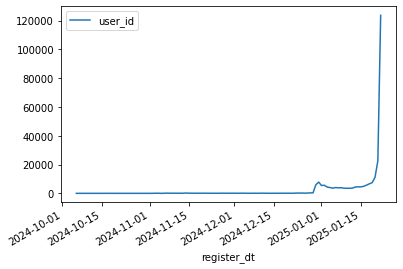

In [5]:
# last 로 필터링 했으므로, 역 지수분포 그림 나옴. 왼쪽 꼬리가 이탈\
df.groupby('register_dt').agg({'user_id':'count'}).plot()

#### 1주일 간 미적립 = 이탈 기준 적용

In [194]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df_.sort_values(by='post_shoji_9',ascending=False)

### 인과 분석
재구매 유저는 행이 여러개임. 단, 매 구매 이후 이탈 확률은 동일하게 부여되므로, 독립적인 세션으로 취급.

In [ ]:
origin = origin_df.copy(deep=True)
origin.columns

In [ ]:
origin.columns

In [ ]:
origin.columns

In [ ]:
origin = origin[['register_dt','user_id','gender','age','pre_cash','current_cash', 'post_shoji_1','post_shoji_6','burnt', 'exchange', 'sub_power','pre_shoji','current_shoji', 'first_pay_amt', 'first_sub_pay_amt']]
origin['spending_power'] = round(origin.apply(lambda x: 0 if x['first_sub_pay_amt'] == 0 else x['first_sub_pay_amt'] / (x['first_sub_pay_amt'] + x['post_shoji_1']), axis=1), 2)
origin['survived'] = origin['post_shoji_6'] > origin['post_shoji_1']
origin = origin[origin['register_dt'] < "2025-01-15" ][['user_id','gender','age','register_dt','pre_cash','current_cash','post_shoji_1','burnt', 'exchange', 'sub_power','pre_shoji','current_shoji', 'first_pay_amt', 'first_sub_pay_amt','spending_power','survived']]


In [ ]:
len(origin),len(tst)

In [ ]:
origin.groupby('user_id').agg({'register_dt':'count'}).query('register_dt > 1')


In [ ]:
origin.groupby('survived').agg({'user_id':'count'})


In [ ]:
tst.groupby('tst').agg({'user_id':'count'})

In [ ]:
random_users = origin['user_id'].sample(n=1)
print(random_users)
tst.query('user_id in @random_users')

### 로짓 전처리

In [27]:
del shoji_diff, users, last_visit,cash_diff
gc.collect()

30

Index(['user_id', 'churn', 'duration', 'register_dt', 'gender', 'age', 'days',
       'user_tier', 'slope_dt', 'avg_event_period', 'current_cash',
       'current_shoji-first', 'current_shoji-last', 'post_shoji_1',
       'post_shoji_2', 'post_shoji_3', 'post_shoji_4', 'post_shoji_5',
       'post_shoji_6', 'post_shoji_7', 'post_shoji_8', 'post_shoji_9',
       'post_shoji_10', 'post_shoji_11', 'post_shoji_12', 'post_shoji_13',
       'burnt', 'burnt_cnt', 'exchange_cnt', 'exchange_cash_rate',
       'cash_difference', 'shoji_difference', 'current_cash_bin',
       'cash_diff_bin'],
      dtype='object')

In [29]:
origin_lg = grp.copy()
origin_lg['churn'] = origin_lg.churn.apply(lambda x : 1 if x == True else 0)

In [30]:
origin_lg.age.value_counts()
origin_lg.loc[origin_lg['age'].isin([90,120]), 'age'] = 80
origin_lg.age.value_counts()

40     84078
50     72402
30     41115
60     25513
20     19222
70      4920
10      4058
80       828
100       15
110        3
Name: age, dtype: Int64

test 1

재산 추가

In [ ]:
origin_lg.describe()

In [ ]:
origin_lg.pre_shoji.hist()

In [ ]:
np.log1p(origin_lg.pre_shoji).hist()

In [ ]:
np.log1p(origin_lg.pre_shoji).describe()

In [ ]:
np.sqrt(origin_lg.pre_shoji).describe()

In [ ]:
# 데이터를 float 타입으로 변환 후 QQ plot 생성
pre_shoji_array = origin_lg.pre_shoji.astype(float)

# 제곱근 변환
pre_shoji_sqrt = np.sqrt(pre_shoji_array)

plt.figure(figsize=(10, 6))
stats.probplot(pre_shoji_sqrt, dist="norm", plot=plt)
plt.title('Q-Q Plot of sqrt(pre_shoji)')
plt.show()

# 로그 변환
pre_shoji_log = np.log1p(pre_shoji_array)

plt.figure(figsize=(10, 6))
stats.probplot(pre_shoji_log, dist="norm", plot=plt)
plt.title('Q-Q Plot of log(pre_shoji)')
plt.show()

In [ ]:
np.sqrt(origin_lg.pre_shoji).hist()

소지 캐시 구간화

In [50]:
pd.set_option('display.max_columns', None)
X.head()

,gender_encoded,slope_dt,avg_event_period,burnt_cnt,exchange_cnt,current_shoji-first,cash_difference,shoji_difference,current_cash_bin,cash_diff_bin_encoded,age_30-50세,age_50-70세,age_70세이상,pre_shoji_낮음,pre_shoji_중간,pre_shoji_높음,current_cash_낮음,current_cash_중간,current_cash_높음,current_cash_매우높음,user_tier_High,user_tier_Inactive,user_tier_Low,user_tier_Medium,user_tier_VeryHigh
1,1,44.119743,1.05,0,0,30,0,832,24000~27000,1,1.000000e+00,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e+00,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e+00,1.000000e+00,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08
2,1,0.000000,0.00,0,0,10,0,0,6000~9000,1,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e+00,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e+00,1.000000e-08,1.000000e-08,1.000000e-08
3,1,64.359684,1.00,0,0,64,0,1344,6000~9000,1,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e+00,1.000000e-08,1.000000e-08,1.000000e+00,1.000000e-08,1.000000e-08,1.000000e+00,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08
4,1,1.628571,2.00,0,0,3,0,30,0~3000,1,1.000000e+00,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e+00,1.000000e-08,1.000000e-08
5,0,4.000000,3.00,0,0,12,0,12,9000~12000,1,1.000000e+00,1.000000e-08,1.000000e-08,1.000000e+00,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e+00,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e+00,1.000000e-08,1.000000e-08


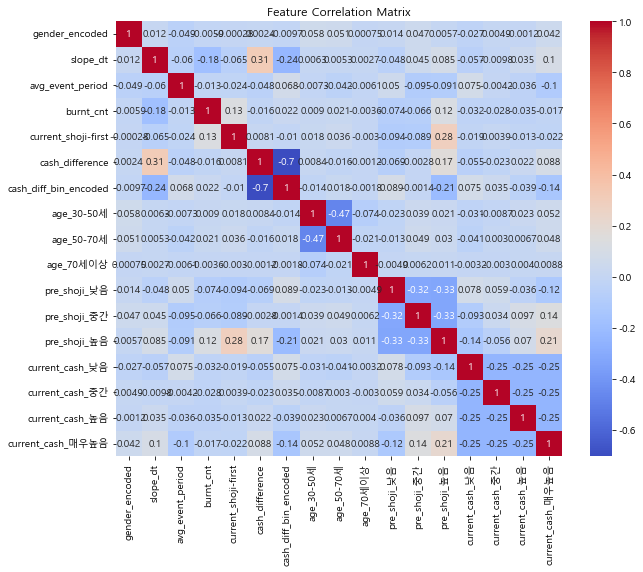


VIF Values:
                            VIF
age_30-50세             1.335308
age_50-70세             1.333129
age_70세이상              1.010766
avg_event_period       1.038833
burnt_cnt              1.078428
cash_diff_bin_encoded  2.047896
cash_difference        2.079682
current_cash_낮음        1.623967
current_cash_높음        1.765503
current_cash_매우높음      1.902989
current_cash_중간        1.681156
current_shoji-first    1.122465
gender_encoded         1.017089
pre_shoji_낮음           1.505542
pre_shoji_높음           1.888603
pre_shoji_중간           1.710920
slope_dt               1.163624

MinMax Scaling Results:
       gender_encoded       slope_dt  avg_event_period      burnt_cnt  \
count   372982.000000  372982.000000     372982.000000  372982.000000   
mean         0.379369       0.453774          0.079108       0.004932   
std          0.477693       0.004027          0.101988       0.031941   
min          0.000000       0.000000          0.000000       0.000000   
25%          0.000000

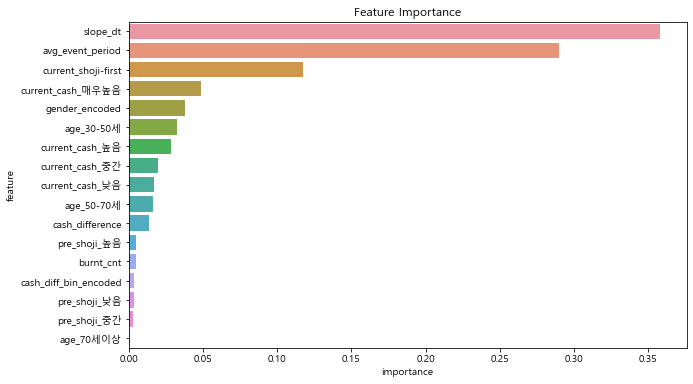

In [59]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder
from numpy import log1p
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression


# 1. 기본 데이터 준비
X = origin_lg[['age','gender', 'user_tier','slope_dt','avg_event_period',
               'burnt_cnt', 'exchange_cnt','current_shoji-first',
                'cash_difference', 'shoji_difference', 'current_cash_bin','cash_diff_bin'
               ]]
y = origin_lg['churn']


le = LabelEncoder()
X['gender_encoded'] = le.fit_transform(X['gender'])
X['cash_diff_bin_encoded'] = le.fit_transform(X['cash_diff_bin'])

# 1. 구간화
pre_shoji_bins = pd.qcut(origin_lg['current_shoji-first'], q=4, labels=['매우낮음', '낮음', '중간', '높음'])
pre_shoji_bins = pd.qcut(origin_lg['current_shoji-first'], q=4, labels=['매우낮음', '낮음', '중간', '높음'])

# 2. 원본 데이터에 구간 추가
origin_lg['pre_shoji_group'] = pre_shoji_bins

# 3. 원핫 인코딩
pre_shoji_dummies = pd.get_dummies(origin_lg['pre_shoji_group'], prefix='pre_shoji') + 1e-8
cur_cash_dummies = pd.get_dummies(origin_lg['current_cash_group'], prefix='current_cash') + 1e-8
# user_tier_dummies = pd.get_dummies(X['user_tier'], prefix='user_tier') + 1e-8

# 20대를 포함한 연령대 재조정
X['age_group'] = pd.cut(X['age'], 
                       bins=[0, 30, 50, 70, 100],  # 20대 구간 추가
                       labels=['30세미만', '30-50세', '50-70세', '70세이상'])
# 다시 원핫 인코딩
age_dummies = pd.get_dummies(X['age_group'], prefix='age',drop_first=True) + 1e-8
# age_dummies = pd.get_dummies(X['age'], prefix='age',drop_first=True)

X.slope_dt.fillna(0,inplace=True)
X.avg_event_period.fillna(0,inplace=True)

X = pd.concat([
   X[['gender_encoded', 
        'age','gender', 'slope_dt','avg_event_period',
        'burnt_cnt'
        # ,'exchange_cnt'
        ,'current_shoji-first',
        'cash_difference'
        # ,'shoji_difference'
        ,'cash_diff_bin_encoded'
      ]], 
   age_dummies
   ,pre_shoji_dummies.drop('pre_shoji_매우낮음', axis=1)  # drop_first=True와 동일한 효과
   ,cur_cash_dummies.drop('current_cash_매우낮음', axis=1)  # drop_first=True와 동일한 효과
   
], axis=1)
X = X.drop(['age','gender'],axis=1)
# print(X.columns)

y = y.astype(int)
X = X.astype(float)

# 2. 데이터 변환 (왜곡된 변수 처리)
X_transformed = X.copy()
# X_transformed['spending_power'] = np.sqrt(X_transformed['spending_power'])



# 3. 상관관계 분석
plt.figure(figsize=(10,8))
correlation = X_transformed.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

# 4. VIF 계산
def calculate_vif(X):
    vif_dict = {}
    for column in X.columns:
        not_column = [col for col in X.columns if col != column]
        y = X[column]
        X_others = X[not_column]
        r2 = r2_score(y, LinearRegression().fit(X_others, y).predict(X_others))
        vif = 1/(1-r2)
        vif_dict[column] = vif
    return pd.DataFrame({'VIF': vif_dict})

vif_df = calculate_vif(X_transformed)
print("\nVIF Values:")
print(vif_df)

# 5. SMOTE 오버샘플링
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_transformed, y)

# 6. 다양한 스케일러 적용 및 비교
scalers = {
    'MinMax': MinMaxScaler(),
    'Standard': StandardScaler(),
    'Robust': RobustScaler()
}

scaled_dfs = {}
for scaler_name, scaler in scalers.items():
    X_scaled = scaler.fit_transform(X_resampled)
    scaled_dfs[scaler_name] = pd.DataFrame(X_scaled, 
                                         columns=X_resampled.columns)
    
    # 스케일링 결과 통계 출력
    print(f"\n{scaler_name} Scaling Results:")
    print(scaled_dfs[scaler_name].describe())

# 7. 변수 중요도 확인
rf = RandomForestClassifier(random_state=42)
rf.fit(scaled_dfs['Standard'], y_resampled)  # StandardScaler 사용

feature_importance = pd.DataFrame({
    'feature': X_transformed.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# 8. 최종 전처리된 데이터셋 준비
# StandardScaler를 기본으로 사용
X_final = scaled_dfs['Standard']
y_final = y_resampled

# 최종 데이터셋 통계 확인
print("\nFinal Dataset Statistics:")
print(X_final.describe())

# 결과 시각화
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.show()

In [55]:
vif_df

,VIF
age_30-50세,1.335308
age_50-70세,1.333129
age_70세이상,1.010766
avg_event_period,1.038833
burnt_cnt,1.078428
cash_diff_bin_encoded,2.047896
cash_difference,2.079682
current_cash_낮음,1.623967
current_cash_높음,1.765503
current_cash_매우높음,1.902989


### reg

In [56]:
# 로지스틱 회귀 분석을 위한 데이터 준비
import statsmodels.api as sm

# 상수항 추가
X = sm.add_constant(X)

# 로지스틱 회귀 모델 적합
model = sm.Logit(y, X)
results = model.fit()

# 결과 출력
results.summary()


Optimization terminated successfully.
         Current function value: 0.513768
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  churn   No. Observations:               252154
Model:                          Logit   Df Residuals:                   252136
Method:                           MLE   Df Model:                           17
Date:                Fri, 24 Jan 2025   Pseudo R-squ.:                  0.1041
Time:                        16:19:46   Log-Likelihood:            -1.2955e+05
converged:                       True   LL-Null:                   -1.4461e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -1.0860      0.063    -17.224      0.000      -1.210      -0.962
gender_encoded           -0.0812      0.010     -8.074      0.000      -0.101      -0.062
slope_dt                 -0.0021   9.28e-05    -23.005      0.000      -0.002      -0.002
avg_event_period         -0.1773      0.003    -64.374      0.000      -0.183      -0.172
burnt_cnt                -0.0573      0.033     -1.763      0.078      -0.121       0.006
current_shoji-first    -5.68e-05   2.89e-06    -19.661      0.000   -6.25e-05   -5.11e-05
cash_difference        5.204e-05      8e-06      6.502      0.000    3.64e-05    6.77e-05
cash_diff_bin_encoded     1.7863      0.061     29.053      0.000       1.666       1.907
age_30-50세               -0.3107      0.011    -28.296      0.000      -0.332      -0.289
age_50-70세               -0.4936      0.018    -28.064      0.000      -0.528      -0.459
age_70세이상                -0.5424      0.093     -5.827      0.000      -0.725      -0.360
pre_shoji_낮음             -0.4229      0.012    -34.161      0.000      -0.447      -0.399
pre_shoji_중간             -0.9518      0.015    -64.816      0.000      -0.981      -0.923
pre_shoji_높음             -0.9128      0.016    -56.962      0.000      -0.944      -0.881
current_cash_낮음          -0.4668      0.014    -33.499      0.000      -0.494      -0.439
current_cash_중간          -0.6313      0.015    -43.083      0.000      -0.660      -0.603
current_cash_높음          -0.7261      0.016    -46.657      0.000      -0.757      -0.696
current_cash_매우높음        -1.0027      0.018    -57.211      0.000      -1.037      -0.968
=========================================================================================
"""

In [220]:
vif_df

,VIF
age_30-50세,1.816629
age_50-70세,1.828475
age_70세이상,1.016486
burnt,1.004794
current_cash_낮음,1.629267
current_cash_높음,1.692493
current_cash_매우높음,1.761435
current_cash_중간,1.675133
exchange,1.066247
first_pay_amt,1.068207


In [66]:
X.cash_diff_bin_encoded.loc[1]

1.0

In [71]:
le.inverse_transform([int(X.cash_diff_bin_encoded.loc[1])])

array(['1000 이하'], dtype=object)

In [87]:
def calc_impact(results, base_prob):
    significant_vars = {var: coef for var, coef in results.params.items() 
                       if results.pvalues[var] < 0.05 and var != 'const'}
    
    impacts = {}
    const = results.params['const']
    for var, coef in significant_vars.items():
        new_prob = np.exp(const + coef)/(1 + np.exp(const + coef))
        impacts[var] = round((new_prob - base_prob) * 100, 2)
    
    return impacts
base_prob = np.exp(results.params['const'])/(1 + np.exp(results.params['const']))
impacts = calc_impact(results, base_prob)

In [88]:
base_prob

0.25236757889572997

In [296]:
(np.exp(0.3198+ 0.3359) / (1+np.exp(0.3198 + 0.3359)) - base_prob)

0.0750886831780615

In [89]:
impacts

{'gender_encoded': -1.5,
 'slope_dt': -0.04,
 'avg_event_period': -3.2,
 'current_shoji-first': -0.0,
 'cash_difference': 0.0,
 'cash_diff_bin_encoded': 41.59,
 'age_30-50세': -5.4,
 'age_50-70세': -8.15,
 'age_70세이상': -8.83,
 'pre_shoji_낮음': -7.13,
 'pre_shoji_중간': -13.71,
 'pre_shoji_높음': -13.3,
 'current_cash_낮음': -7.77,
 'current_cash_중간': -10.02,
 'current_cash_높음': -11.2,
 'current_cash_매우높음': -14.22}

In [175]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                 5766
Model:                          Logit   Df Residuals:                     5753
Method:                           MLE   Df Model:                           12
Date:                Thu, 23 Jan 2025   Pseudo R-squ.:                 0.07167
Time:                        13:54:11   Log-Likelihood:                -2880.8
converged:                       True   LL-Null:                       -3103.2
Covariance Type:            nonrobust   LLR p-value:                 1.201e-87
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.5431      0.160     -3.391      0.001      -0.857      -0.229
gender_encoded    -0.1297      0.072     -1.807      0.071      -0.270       0.011
spending_power     0.6215      0.151      4.114      0.000       0.325       0.918
exchange          -0.3856      0.101     -3.828      0.000      -0.583      -0.188
burnt              0.2423      0.404      0.599      0.549      -0.550       1.034
first_pay_amt   1.185e-06   1.88e-06      0.631      0.528    -2.5e-06    4.87e-06
current_cash   -3.898e-05    2.8e-06    -13.913      0.000   -4.45e-05   -3.35e-05
shoji_diff     -4.541e-05   6.89e-06     -6.593      0.000   -5.89e-05   -3.19e-05
shoji_ratio     1.374e-11   8.87e-12      1.548      0.122   -3.65e-12    3.11e-11
sub_power          0.0632      0.128      0.493      0.622      -0.188       0.315
age_30-50세        -0.4664      0.085     -5.501      0.000      -0.633      -0.300
age_50-70세        -0.6644      0.116     -5.740      0.000      -0.891      -0.438
age_70세이상         -0.8545      0.781     -1.094      0.274      -2.386       0.677
==================================================================================
"""

In [179]:
np.exp(0.6215)

1.861718526249198

In [191]:
origin_lg.survived

3        0
5        0
9        0
12       0
13       1
        ..
16502    1
16503    1
16507    0
16512    1
16513    1
Name: survived, Length: 5766, dtype: int64

unique 